# What are the most active subreddits?

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import gc
import numpy as np
import linkpred
from linkpred.evaluation import Pair
from  link_prediction import remove_useless_data
import seaborn as sns

def find_rank(subreddit,ranked_list,verbose=False):
    i=0
    value = 0
    l = len(ranked_list)
    for (k,v) in ranked_list:
        i= i+1
        if k == subreddit:
            value = v 
            if verbose == True:
                print("The subreddit {} is in the top {:.2f}% most important subreddits".format(subreddit,i/l*100))
            break
    return value


In [2]:
# load and clean data
data = pd.read_csv("../scraping data/data/data_subreddit_cleaned.csv",index_col=0)
data = remove_useless_data(data)
#add weights
data["weights"] = np.log(data["score"]+data["comments"]+1)
#convert dataframe into graph
g = nx.convert_matrix.from_pandas_edgelist(data ,source = "parent",target="to",
                                           edge_attr=True, create_using=nx.MultiDiGraph())
g_dir = nx.convert_matrix.from_pandas_edgelist(data ,source = "parent",target="to",
                                           edge_attr=True, create_using=nx.DiGraph())

In [3]:
most_parent = data["parent"].value_counts().head(100).index.to_list()
parent_val = data["parent"].value_counts().head(100).to_list()

In [4]:
most_to = data["to"].value_counts().head(100).index.to_list()
to_val = data["to"].value_counts().head(100).to_list()


In [5]:
oldest = data.sort_values(by="date",ascending = False)

# 1) Content creators

I wanted to analyze the characteristic of the subreddits that created the most original content (OC for now on). In order to do so I took the top 100 subreddits with the most OC and I classified them in according to their: <br> 
1. Number of members <br>
    > very high = num members > 10.000.000 <br>
    > high = num members > 1.000.000 <br>
    > medium = num members > 100.000 <br>
    > low = num members > 10.000 <br>
    > very low = num members < 10.000 <br>
2. Type <br>
    > News: Subreddits focused on sharing news (example r/environment) <br>
    > Media share:  Subreddits focused on sharing media like images, videos gifs etc (example r/memes) <br>
    > Community: Subreddits composed of people sharing a common interest (example r/gaming) <br>
2. Theme <br>
    > Politics: (example r/Europe) <br>
    > Animals\nature: (example r/awww) <br>
    > Science: (example r/technology)<br>
    > Memes: (example r/funny) <br>
    > News: News subreddits that are not focused on a single topic (example r/news) <br>
    > Melting pot: There is not a main theme, but rather a mixture of all the themes I listed above (example r/BeAmazed) <br>

In [6]:
data_parents = pd.read_csv("../scraping data/data/data_parents.csv",index_col=0,sep=";")
data_parents.head(10)

,Subreddit,Members,Type,Theme
0.0,politics,high,News,politics
1.0,interstingasfuck,high,Media share,melting pot
2.0,PublicFreakout,high,Media share,politics
3.0,nextfuckinglevel,high,Media share,melting pot
4.0,aww,very high,Media share,animals
5.0,funny,very high,Media share,memes
6.0,Unexpected,high,Media share,memes
7.0,worldnews,very high,News,politics
8.0,news,very high,News,news
9.0,Damnthatsinteresting,high,Media share,melting pot


After I created this dataframe, I took the top 25 subreddits and analyzed the distribution of the variuos class types

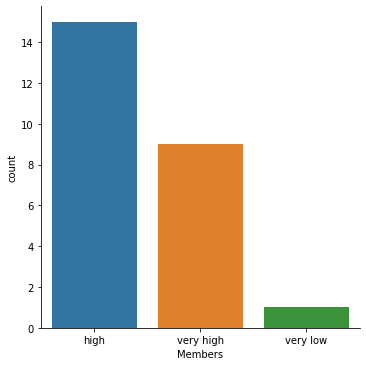

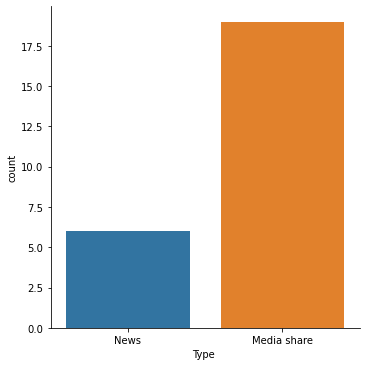

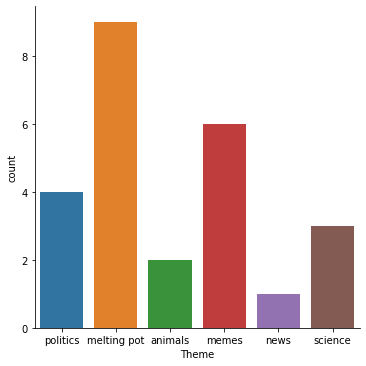

In [13]:
for i,column in enumerate(data_parents):
    if column != "Subreddit" and column != "interactions":
        sns.catplot(data=data_parents.head(25),x=column,kind="count")
        plt.savefig(f"images/top_25_{i}.png")

The most interesting things we can see from the histograms below are: <br>
> 1) Almost all the subreddits in the top 25 have a high/very high number of members apart from r/ForUnitedStates which has only 4k members <br>
> 2) There are no community subreddits in the top 25 and almost all of them are media share subreddits <br>
> 3) The themes of the subreddits are quite diverse
    

### A closer look to r/ForUnitedStates 

Among the top 25 subreddits all of them have a very high or high number of members apart from r/ForUnitedStates which has circa 4k members. Is this due to SPAM or is this organic? Let's take a closer look

In [8]:
for_un = data[data["parent"] == "ForUnitedStates" ]
titles = pd.unique(for_un["title"])
print("Number of total crossposts to other subreddits: {}".format(len(for_un)))
print("Number of unique posts created in r/ForUnitedStates {}".format(len(titles)))
print("Avarage number of comments: {:.2f}".format(for_un["comments"].mean()))
print("Avarage number of upvotes: {:.2f}".format(for_un["score"].mean()))
non_0_c = for_un[for_un["comments"] !=0.]["comments"].mean()
non_0_up = for_un[for_un["score"] !=0.]["score"].mean()
print("Avarage number of comments excluding posts with 0 comments: {:.2f}".format(non_0_c))
print("Avarage number of upvotes excluding posts with 0 upvotes: {:.2f}".format(non_0_up))
most_popular = for_un.groupby("title").sum()
most_popular.sort_values(by="score",ascending=False,inplace=True)
print("5 most popular posts:" )
print(most_popular["score"].head(5))

Number of total crossposts to other subreddits: 1929
Number of unique posts created in r/ForUnitedStates 405
Avarage number of comments: 1.01
Avarage number of upvotes: 9.25
Avarage number of comments excluding posts with 0 comments: 3.53
Avarage number of upvotes excluding posts with 0 upvotes: 9.59
5 most popular posts:
title
Sens. Bernie Sanders (I-Vt.) and Josh Hawley (R-Mo.) introduced a bipartisan amendment to Congress Thursday, which if passed would provide $1,200 in direct payments to working-class adults and $500 to each of their children.                                                    1111.0
President says US will have enough supply of the vaccine by the end of the summer to inoculate 300 million Americans. US is on pace to exceed goal of administering 100 million vaccine doses                                                                                        807.0
Kansas To Remove Cannabis As An Impairing Drug. 'The new bills, known as House Bill 2040, would remove c

From this preliminary analysis we can see that this is a news subreddit that deals with mostly left-wing topics. Let's take a closer look on where the most popolar posts are crossposted. 

In [9]:
new_un = for_un.sort_values(by="score",ascending=False)
ego_un = nx.convert_matrix.from_pandas_edgelist(new_un.head(100) ,source = "parent",target="to",
                                           edge_attr=True, create_using=nx.DiGraph())

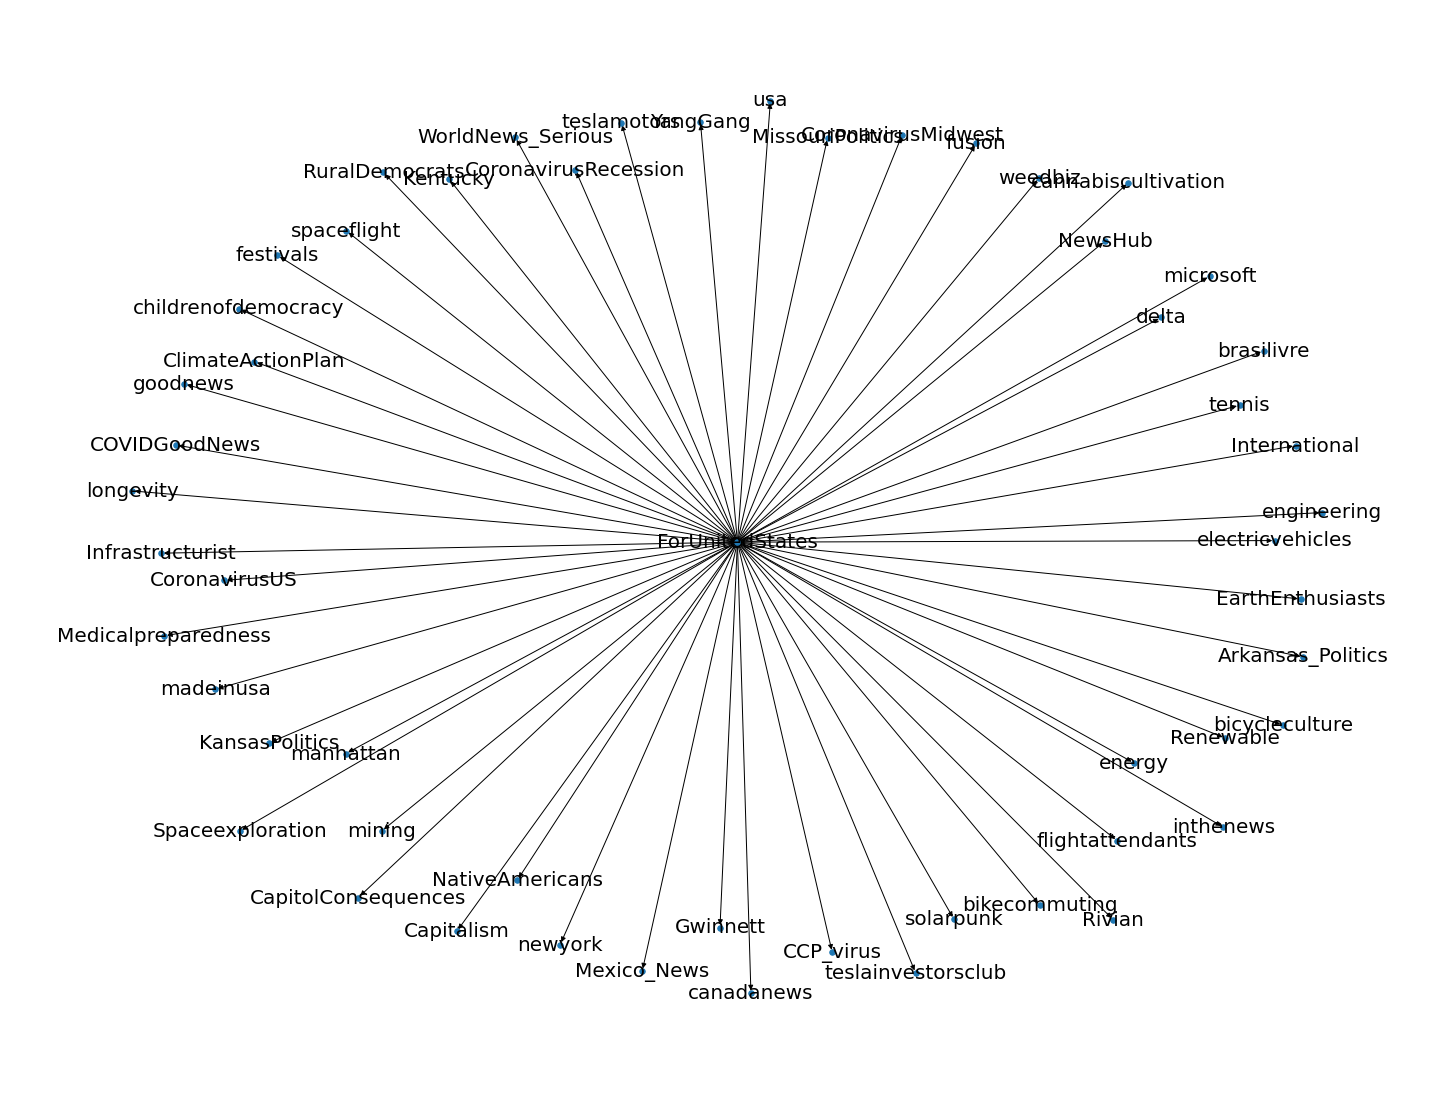

In [10]:
plt.figure(figsize=(20,15))
nx.draw(ego_un,node_size=30,with_labels=True,font_size=20)

Let's analyze the avarage number of interactions (comment + upvotes) for each top 25 subreddit and see how r/ForUnitedStates compares

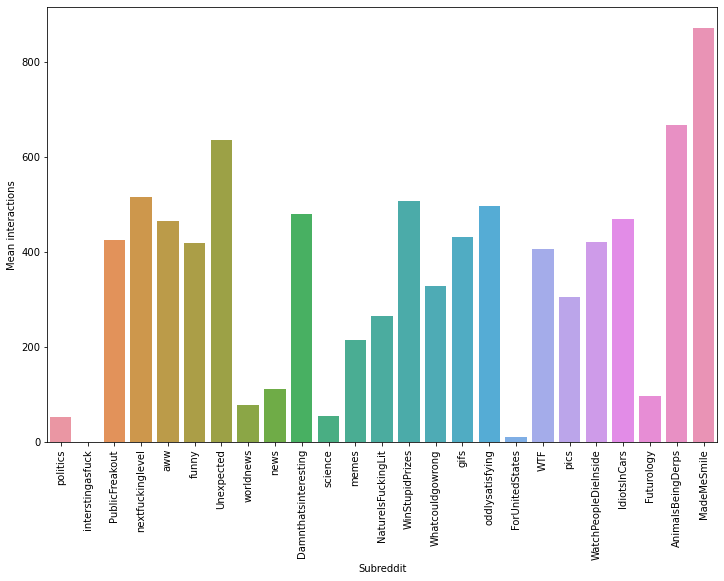

In [28]:
interactions = []
for subreddit in data_parents["Subreddit"]:
    sub = data[data["parent"] == subreddit]
    interactions.append((sub["comments"]+sub["score"]).mean())

data_parents["interactions"] = interactions
    
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.barplot(axes=ax,data=data_parents.head(25),x="Subreddit",y="interactions")
plt.ylabel("Mean interactions")
plt.savefig("images/interactions_1.png")
plt.show()

    
    

At a first glance it seems that r/ForUnited high number of crossposted OC may be due to spam, but if we filter the results by subreddit type we can see something interesting

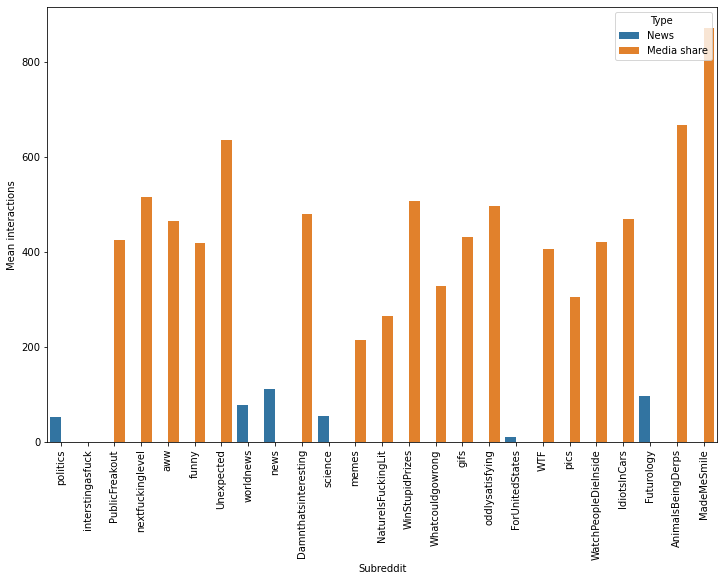

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.barplot(axes=ax,data=data_parents.head(25),x="Subreddit",y="interactions",hue="Type ")
plt.ylabel("Mean interactions")
plt.savefig("images/interactions_2.png")
plt.show()

As we can see all the news subreddits generates a lower amount of interactions in respect to the media share subreddits. This means that it is completely possible that r/ForUnitedStates connections are genuine.

In [55]:
print("mean interactions by type:")
data_parents.groupby("Type ")["interactions"].mean()

mean interactions by type:


Type 
Community      151.223091
Media share    454.759939
News            86.221828
Name: interactions, dtype: float64

Focusing on the top 100 subreddits it is clear that media share subreddits are by far the most popular.

Let's now analyze the top 100 subreddits

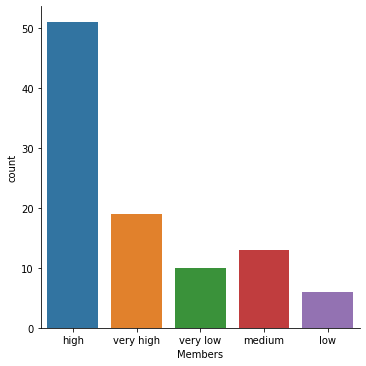

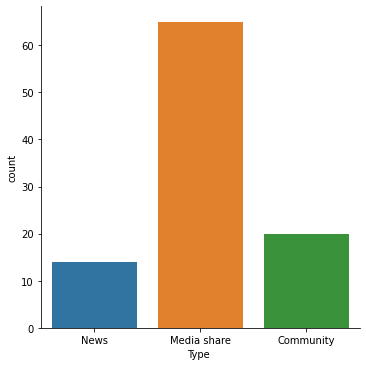

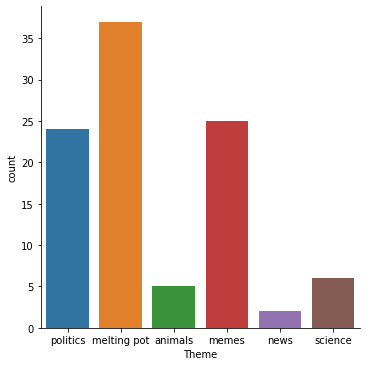

In [19]:
for i,column in enumerate(data_parents):
    if column != "Subreddit" and column !="interactions":
        sns.catplot(data=data_parents,x=column,kind="count")
        plt.savefig(f"images/top_100_{i}.png")

The most interesting things we can see from the histograms below are: <br>
> 1) Most subreddits have more than 1M members but there are 10 subreddits with less than 10k <br>
> 2) There are more community subreddits, but the majority if them are media share subreddits <br>
> 3) The themes are dominated by politics memes and melting pot
    

## 2) Content reposter

Let's now analyze the characteristics of the subreddits with the most number of reposted content. I focused initially on the top 25 subreddits

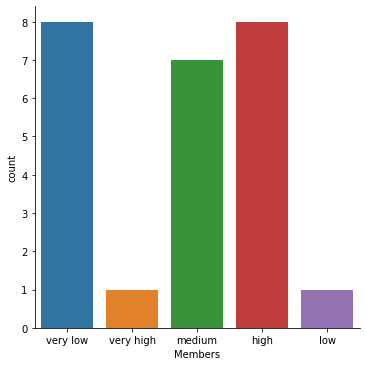

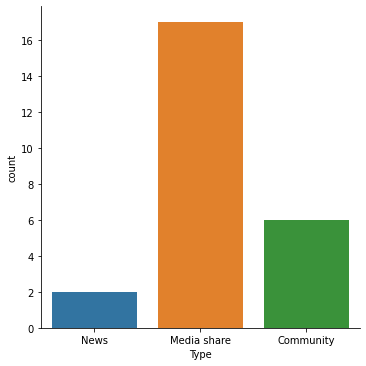

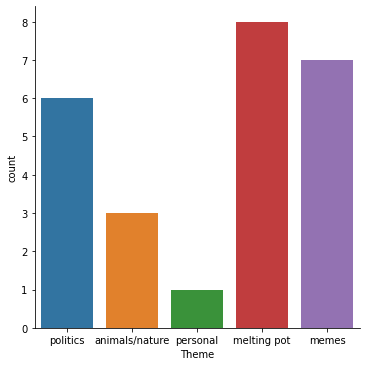

In [21]:
reposter = pd.read_csv("../scraping data/data/reposts.csv",sep=";")
reposter.head(10)
for i,column in enumerate(reposter):
    if column != "Subreddit":
        sns.catplot(data=reposter.head(25),x=column,kind="count")
        plt.savefig(f"images/reposters_25_{i}.png")

As we can see the results are a lot different from the previous analysis. In particular:<br>
> 1) The subreddits have a much lower number of members <br>
> 2) There are fewer news subreddits and more community subreddits <br>
> 3) There are no science subreddits but there are personal subreddits. Those are private subreddits created and operated by a single redditor, in which all posts are crossposts from other subreddits.<br> The reason why those exist is because there is a limit of 1000 posts a single redditor can save and once this limit is reached a personal subreddit is created  in order to continue to save posts.

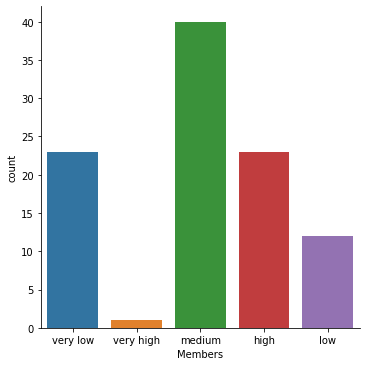

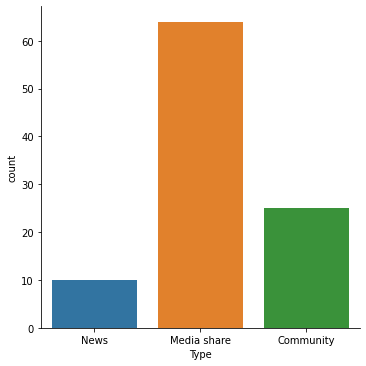

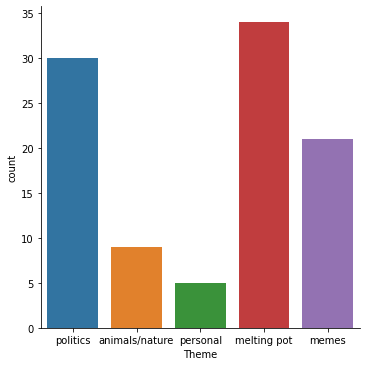

In [22]:
for i,column in enumerate(reposter):
    if column != "Subreddit":
        sns.catplot(data=reposter,x=column,kind="count")
        plt.savefig(f"images/reposters_100_{i}.png")

Once again the results are very interesting in particular: <br>
> 1) There is only 1 subreddit with number of member over 10M and the majority of them are in the range 100k-1M.<br> This may be caused by the fact that those smaller subreddits have less active users and are at the same time more niche, so less original content is created.

## 3) Crossposts 

Firstly I too the top 1.000 viral posts (the one having the highest number of upvotes) and I saw in how many other subreddits they were posted

In [32]:
data = pd.read_csv("../scraping data/data/data_subreddit_cleaned.csv",index_col=0)
data = remove_useless_data(data)
most_viral = data.groupby("title")["score"].sum()
most_viral.sort_values(inplace=True,ascending=False)
lst_viral = most_viral.head(1000).index.to_list()
n_cross = []
most_viral.head(10)

title
Cop chokes and punches teenage girl in the head after breathalyzer comes up negative                                                                                                                                                                147660.0
Why we protest                                                                                                                                                                                                                                      109947.0
Turns out this selfish church who had a maskless vigil forgot how the internet works. They are now trying to remove all footage of this video from the internet. Please share everywhere.                                                           109882.0
She was having a lovely day playing in the pool until it all went terribly wrong.                                                                                                                                                          

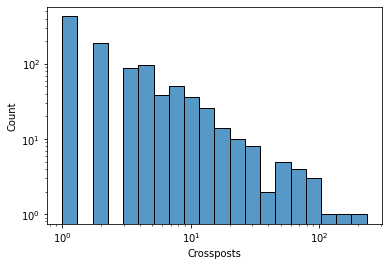

In [33]:
for title in lst_viral:
    n_cross.append((data[data["title"]==title]).shape[0])
sns.histplot(n_cross,log_scale=(True,True))
plt.xlabel("Crossposts")
plt.savefig(f"images/cross_1000.png")

Surprisingly the number of subreddits its very low, infact the majority of the posts were crossposted in only 1 other subreddit.
Lets see the top 10.000 viral posts and see how they compare.

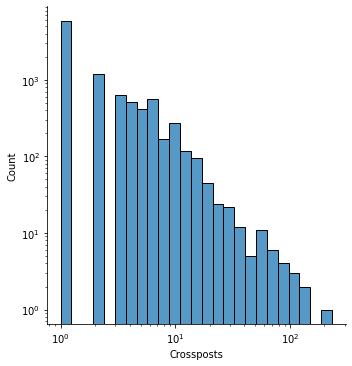

In [34]:
lst_viral_2 = most_viral.head(10000).index.to_list()
n_cross = []
for title in lst_viral_2:
    n_cross.append((data[data["title"]==title]).shape[0])

sns.displot(n_cross,kind="hist",bins=25,log_scale=(True,True))
plt.xlabel("Crossposts")
plt.savefig(f"images/cross_10000.png")

Once again the number is very low. Let's see now the distribution of all posts

In [26]:
lst_viral_all = most_viral.index.to_list()
n_cross = []
for title in lst_viral_all:
    n_cross.append((data[data["title"]==title]).shape[0])

sns.displot(n_cross,kind="hist",bins=25,log_scale=(True,True))
plt.savefig(f"images/cross_all.png")

KeyboardInterrupt: 

Once again the number of subreddits is quite low even for the most crossposted posts.